# Stage 1: Enhanced Data Cleaning, Preprocessing, and Exploratory Analysis
In this notebook, we perform **data cleaning, preprocessing, and exploratory analysis (EDA)** on the Cleantech Media and Google Patent datasets. The goal is to identify **trends, key technologies, and innovation gaps** by analyzing media publications and patents.

In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install contractions
!pip install unidecode
!pip install num2words
!pip install langdetect
!pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=77e2a037339ad62af946b1c013cc4c231208b722dd4085caa4889d9e5f4abb18
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=fbef7bab7ce5aec3c882b124b04ed2a53f68d8df1d5cbf42eb9fb3ec1748b59d
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05

For the spell correction we have chosen the SymSpell library, since the SpellChecker runs significantly longer (without success).

In [3]:
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt

--2025-03-15 07:29:36--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.06s   

2025-03-15 07:29:37 (19.9 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332881/1332881]



In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import re
import nltk
import spacy
import string
import contractions
import unidecode
from tqdm import tqdm
from num2words import num2words
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from symspellpy import SymSpell, Verbosity
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Data Collection and Cleaning (Joshua)
Before analyzing the data, we first **load, inspect, and clean** the datasets:  

- **Load datasets**: We import the **Cleantech Media Dataset** and the **Cleantech Google Patent Dataset** into Pandas DataFrames.  
- **Remove duplicates**: Identical or near-identical entries are removed to prevent data bias.  
- **Handle missing values**: We check for null or incomplete entries and decide whether to impute, replace, or remove them.  
- **Filter relevant information**: Non-informative texts (e.g., generic statements) are removed to ensure high-quality analysis.  

In [10]:
# Load raw data, stored in the private google drive
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
media_dataset_path = data_folder / "data/cleantech_media_dataset_v3_2024-10-28.csv"
google_patent_dataset_path = data_folder / "data/CleanTech_22-24_updated.json"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150)

### Cleantech Media Dataset - Preprocessing

In [6]:
# Load CSV files
df_media = pd.read_csv(media_dataset_path, header = 0)

print(df_media.info())
df_media

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20111 entries, 0 to 20110
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20111 non-null  int64  
 1   title       20111 non-null  object 
 2   date        20111 non-null  object 
 3   author      0 non-null      float64
 4   content     20111 non-null  object 
 5   domain      20111 non-null  object 
 6   url         20111 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB
None


,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,"['Chinese automotive startup XPeng has shown one of the most dramatic auto production ramp-ups in history, and the good news is it only produces 100% smart electric vehicles ( EVs). At a mere 7 years of age, and just a few years after launching its first vehicle ( the XPeng G3 went on sales in D...",cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,"['Sinopec has laid plans to build the largest green hydrogen production facility in the world, but interest in fossil-sourced hydrogen continues apace.', 'Skepticism abounds over the green hydrogen field, and yet leading players on the global energy stage seem willing to give it a whirl. In the ...",cleantechnica,https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-make-a-splash/
2,98159,World’ s largest floating PV plant goes online in China – pv magazine International,2022-01-03,NaN,"['Huaneng Power International has switched on a 320 MW floating PV array in China’ s Shandong province. It deployed the plant in two phases on a reservoir near its 2.65 GW Dezhou thermal power station.', ""Huaneng Power International ( HPI) has completed the world's largest floating PV project – ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/
3,98158,Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International,2022-01-03,NaN,"['According to the Iranian authorities, there are currently more than 80GW of renewable energy projects that were submitted by private investors for review.', 'Iran had around 414MW of installed solar power at the end of 2020.', 'The Iranian Energy Ministry announced, last week, a plan to add an...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-four-years/#comments
4,31128,Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’,2022-01-03,NaN,"['Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily emails.', 'Your email address *', 'Your password *', 'Remember me Continue', 'Reset password', 'Featured Content', 'News & Data Services', 'Client Support', 'Daily GPI', 'Infrastructure | NGI Al...",naturalgasintel,https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-ways/
...,...,...,...,...,...,...,...
20106,104263,US Treasury finalises 45X Advanced Manufacturing tax credit rules,2024-10-24,NaN,"['The US Department of the Treasury ( DOT) has finalised its rules for the 45X Advanced Manufacturing Production Tax Credit, as part of the US’ ongoing efforts to encourage greater domestic production of components and technologies integral to the clean energy transition.', 'The 45X tax credit a...",pv-tech,https://www.pv-tech.org/us-treasury-finalises-45x-advanced-manufacturing-tax-credit-rules/
20107,104264,EDP trials robotic construction on Spanish PV project,2024-10-24,NaN,"['Developer EDP is piloting a robotic construction solution on a 122MW PV power plant in Valladolid, Spain, through which it hopes to significantly cut the project’ s build time.', 'The Hyperflex technology, developed by Italian robotics specialist Comau, will be used on a 3MW section of Peñaflo...",pv-tech,https://www.pv-tech.org/edp-trials-robotic-construction-spanish-pv-project/
20108,101434,Australia has 7.8 GW of utility-scale batteries under construction – pv magazine International,2024-10-24,NaN,"['The volume of large-scale battery energy storage projects under construction in Australia passed that of solar and wind projects combined in 2023 and the trend has intensified this year, with batteries attracting federal support. As coal-fired power plants are shuttered, developers and supplie..

As we can see above, the media dataset contains 7 columns and roughly 20'000 rows. The most important column will be the content. To get a first overview, we look at the different domains or rather the publisher:

In [7]:
# Count occurrences of each unique value in the 'domain' column
domain_counts = df_media['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              4181
pv-magazine              3093
azocleantech             2488
cleantechnica            2089
pv-tech                  1969
thinkgeoenergy           1052
solarpowerportal.co       850
energyvoice               828
solarpowerworldonline     785
solarindustrymag          621
solarquarter              606
rechargenews              573
naturalgasintel           298
iea                       173
energyintel               171
greenprophet              130
greenairnews               59
ecofriend                  55
all-energy                 39
decarbxpo                  20
storagesummit              15
eurosolar                   9
indorenergy                 4
bex-asia                    2
biofuels-news               1
Name: count, dtype: int64


To further work with the dataset, the raw data is safed in a new dataframe. The author-column is removed since there are no entries.

In [8]:
# Create a new dataframe for the processed data
df_media_preprocessed = df_media.rename(columns={df_media.columns[0]: 'id'})
df_media_preprocessed.drop(columns=['author'], inplace=True)

Let's format all columns to a defined type and further check if there are any duplicates in id:

In [ ]:
# Convert columns to the required data types
df_media_preprocessed['title'] = df_media_preprocessed['title'].astype(str)
df_media_preprocessed['content'] = df_media_preprocessed['content'].astype(str)
df_media_preprocessed['domain'] = df_media_preprocessed['domain'].astype(str)
df_media_preprocessed['url'] = df_media_preprocessed['url'].astype(str)
df_media_preprocessed['date'] = pd.to_datetime(df_media_preprocessed['date'], errors='coerce')
df_media_preprocessed['id'] = df_media_preprocessed['id'].astype(int)

# Check for duplicates
duplicate_ids = df_media_preprocessed[df_media_preprocessed.duplicated(subset=['id'])]
print(duplicate_ids)
df_media_preprocessed

Empty DataFrame
Columns: [id, title, date, content, domain, url]
Index: []


,id,title,date,content,domain,url
0,93320,"XPeng Delivered ~100,000 V...",2022-01-02,['Chinese automotive start...,cleantechnica,https://cleantechnica.com/...
1,93321,Green Hydrogen: Drop In Bu...,2022-01-02,['Sinopec has laid plans t...,cleantechnica,https://cleantechnica.com/...
2,98159,World’ s largest floating ...,2022-01-03,['Huaneng Power Internatio...,pv-magazine,https://www.pv-magazine.co...
3,98158,Iran wants to deploy 10 GW...,2022-01-03,['According to the Iranian...,pv-magazine,https://www.pv-magazine.co...
4,31128,Eastern Interconnection Po...,2022-01-03,['Sign in to get the best ...,naturalgasintel,https://www.naturalgasinte...
...,...,...,...,...,...,...
20106,104263,US Treasury finalises 45X ...,2024-10-24,['The US Department of the...,pv-tech,https://www.pv-tech.org/us...
20107,104264,EDP trials robotic constru...,2024-10-24,['Developer EDP is pilotin...,pv-tech,https://www.pv-tech.org/ed...
20108,101434,Australia has 7.8 GW of ut...,2024-10-24,['The volume of large-scal...,pv-magazine,https://www.pv-magazine.co...
20109,101428,Residential PV prices in G...,2024-10-24,['The comparison site Self...,pv-magazine,https://www.pv-magazine.co...


There are no duplicates id's in the dataset.

A manual inspection of the content shows, that the scraping of the websites not only contain the desired content but also some unneccessairy information like cookie references:

In [11]:
# Extract the 'content' for each ID
content_23099 = df_media_preprocessed[df_media_preprocessed['id'] == 23099]['content'].values[0]
content_23100 = df_media_preprocessed[df_media_preprocessed['id'] == 23100]['content'].values[0]

# Create a comparison table
comparison_table = pd.DataFrame({
    'ID 23099 Content': [content_23099],
    'ID 23100 Content': [content_23100]
})

# Display the table
print(comparison_table)

                                                                                                                                        ID 23099 Content  \
0  ['We use cookies to enhance your experience. By continuing to browse this site you agree to our use of cookies. More info.', 'In a groundbreaking ...   

                                                                                                                                        ID 23100 Content  
0  ['We use cookies to enhance your experience. By continuing to browse this site you agree to our use of cookies. More info.', 'There are multiple m...  


Since the content column was predefined as a list and the desired content somtimes start at index 0 and sometimes at index 1, a removal of prefixes is possible. In addition in some cells there are also some suffixes that are not part of the content itself. These parts also shall be removed.

In [12]:
# List of unwanted suffixes
unwanted_suffixes = [
    "Need help finding the right suppliers?",
    "Energy XPRT is part of XPRT Media All Rights Reserved. Terms Privacy",
    "Your email address will not be published. Required fields are marked",
    "Hi, I 'm Azthena, you can trust me to find commercial scientific answers",
    "Copyright",
    "To use the full function of this web site",
    "EcoFriend.com ",
    "EuropÃ¤ische Vereinigung",
    "Get updates on the IEA",
    "About us",
    "This website uses cookies to",
    "Recharge is part of DN Media Group",
    "Solar Industry offers industry participants probing",
    "Thank you for subscribing to the email newsletter",
    "This site uses Akismet to reduce spam"
]

# List of unwanted prefixes
unwanted_prefixes = [
    "By clicking `` Allow All '' you agree ",
    "We use cookies to enhance your experience",
    "Sign in to get the best natural gas news and data",
    "Your email address *",
    "Your password *",
    "Remember me Continue",
    "Reset password",
    "Featured Content",
    "News & Data Services",
    "Client Support",
    "- May 27, 2022 - With the innovation and development",
    "A consortium of Mitsubishi Power Americas",
    "Advanced Energy's WaveCapture",
    "Check out a tour of Solar Turbines ' Configurable Modular",
    "Benefits of Combined Heat & Power ( Cogeneration) Website",
    "window.dojoRequire",
    "Accurate Wind Resource Assessment. Power Performance Verification",
    "Create a free IEA account to download",
    "Equip yourself with various operating voltages and advanced control",
    "FLOWSTAR-Energy is a practical, high resolution model "
    "Hydrogen Technology Expo & Carbon Capture Technology Expo was held in Bremen",
    "By Power Vision Engineering Sarl based in Ecublens",
    "Power Vision Engineering provides various...",
    "Shenzhen Power Kingdom Co., Ltd. is one of the subsidiaries of Henan Yuguang Gold",
    "This course investigates",
    "This course examines",
    "Welcome to Edinburgh Instruments",
    "Create a free IEA account to download our reports or subcribe"
]

def remove_unwanted_prefixes(content):
    if isinstance(content, str):
        try:
            content_list = eval(content)
            if isinstance(content_list, list):
                content_list = [
                    item for item in content_list
                    if not any(item.startswith(prefix) for prefix in unwanted_prefixes)
                ]
                return str(content_list)  # Convert back to string if needed
        except:
            pass  # Ignore errors if content is not a valid list
    return content


def remove_unwanted_suffixes(content):
    if isinstance(content, str):
        for phrase in unwanted_suffixes:
            index = content.find(phrase)
            if index != -1:
                return content[:index].strip()  # Keep only the part before the phrase
    return content

df_media_preprocessed['content'] = df_media_preprocessed['content'].apply(remove_unwanted_suffixes)
df_media_preprocessed['content'] = df_media_preprocessed['content'].apply(remove_unwanted_prefixes)

In [13]:
content_23099 = df_media_preprocessed[df_media_preprocessed['id'] == 23099]['content'].values[0]
content_23100 = df_media_preprocessed[df_media_preprocessed['id'] == 23100]['content'].values[0]

# Create a comparison table
comparison_table = pd.DataFrame({
    'ID 23099 Content': [content_23099],
    'ID 23100 Content': [content_23100]
})

# Display the table
print(comparison_table)

                                                                                                                                        ID 23099 Content  \
0  ['In a groundbreaking leap towards revolutionizing microbial fuel cell ( MFC) technology, recent research has unveiled a transformative solution t...   

                                                                                                                                        ID 23100 Content  
0  ['There are multiple methods for harnessing solar energy to separate water and generate hydrogen. Regrettably, this eco-friendly hydrogen has rema...  


As we can see above, the prefixes (and suffixes) are removed.

For a easier handling of the preprocessed data, the dataframe is safed as a seperate .csv-file that later can be loaded without running all the cells again.

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_pre-cleaned.csv"
df_media_preprocessed.to_csv(save_path, index=False)

### Cleantech Google Patent Dataset - Preprocessing

A similar approach is done with the google patent dataset:

In [ ]:
df_google_patents = pd.read_json(google_patent_dataset_path, lines=True)
print(df_google_patents.info())
df_google_patents

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406857 entries, 0 to 406856
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   publication_number  406857 non-null  object
 1   application_number  406857 non-null  object
 2   country_code        406857 non-null  object
 3   title               406857 non-null  object
 4   abstract            406857 non-null  object
 5   publication_date    406857 non-null  int64 
 6   inventor            406857 non-null  object
 7   cpc_code            406857 non-null  object
dtypes: int64(1), object(7)
memory usage: 24.8+ MB
None


,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
0,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,The application provides a...,20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0654
1,CN-117151396-A,CN-202311109834-A,CN,Distributed economic sched...,The invention discloses a ...,20231201,"[HU PENGFEI, LI ZIMENG]",G06Q50/06
2,CN-117141530-A,CN-202310980795-A,CN,氢能源动力轨道车辆组,The invention discloses a ...,20231201,"[XIE BO, ZHANG SHUIQING, Z...",Y02T90/40
3,CN-117141244-A,CN-202311177651-A,CN,一种汽车太阳能充电系统、方法及新能源汽车,The application discloses ...,20231201,[ZHAO PENGCHENG],B60K16/00
4,CN-117146094-A,CN-202311272549-A,CN,一种水利水电管道连接装置,The invention provides a w...,20231201,"[LYU SHUOSHUO, LI PANFENG,...",F16L55/02
...,...,...,...,...,...,...,...,...
406852,CN-113887946-A,CN-202111162179-A,CN,Emergency material transpo...,The application discloses ...,20220104,"[QI QINGJIE, LIU HAN, LIU ...",G06Q10/0631
406853,TW-202201895-A,TW-109121032-A,TW,Fish farming system capabl...,The present invention rela...,20220101,"[WANG, YI-FENG]",Y02E10/50
406854,TW-202201895-A,TW-109121032-A,TW,魚類養殖系統,The present invention rela...,20220101,"[WANG, YI-FENG]",Y02E10/50
406855,TW-202201895-A,TW-109121032-A,TW,Fish farming system capabl...,The present invention rela...,20220101,"[WANG, YI-FENG]",Y02B10/10


There are over 400 thousand rows with 8 columns. As we can see in the last entries of the dataframe above, there must be several duplicates! Rows 406853 to 406856 have the same publication_number and also the abstract seems to be the same. There are some differences in the columns title, where different languages seem to be present and also the cpc_codes do have some minor variances. First let's look which publication number occurs how many times in the dataset:

In [ ]:
df_counts = df_google_patents["publication_number"].value_counts().reset_index()
df_counts.columns = ["publication_number", "count"]
df_counts = df_counts.sort_values(by="count", ascending=False)

print(df_counts)

      publication_number  count
0          EP-3969821-A2    550
1          EP-4237625-A1    450
2       WO-2022089858-A1    450
3          EP-4326671-A1    390
4       WO-2023124030-A1    370
...                  ...    ...
31355     ZA-202305543-B      1
31354      NL-2032498-B1      1
31353       TW-M626789-U      1
31351      NL-2028183-B1      1
31365         SI-26447-A      1

[31366 rows x 2 columns]


As we can see above, there are roughly 32 thousand individual publication_numbers. As already mentioned the duplicates differ in either their language or their cpc_code.

The cpc  (Cooperative Patent Classification) code is part of a classification system used to categorize patents based on their technical content.

**Structure of CPC Codes:**

CPC codes are hierarchical and consist of:

- Section (e.g., Y)
- Class (e.g., Y02)
- Subclass (e.g., Y02B)
- Group (e.g., Y02B10)
- Subgroup (e.g., Y02B10/10 or Y02B10/20)

A single patent can be classified under multiple CPC codes if its invention covers aspects of different categories.

To get rid of all those duplicates, the text in the column "title" and "abstract" shall be checked if it is in english. If yes, the entry shall be kept and else the duplicate is removed. If there are still duplicates, only the first one is kept:

In [ ]:
# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False  # Handle cases where text is empty or cannot be detected

publication_numbers_to_check = df_counts["publication_number"].tolist()
df_filtered = df_google_patents[df_google_patents["publication_number"].isin(publication_numbers_to_check)]

# To keep track of the progress, we display a progress bar:
tqdm.pandas(desc="Checking language")

# Apply language detection on the filtered dataset
df_filtered["is_english"] = df_filtered.progress_apply(
    lambda row: is_english(str(row["title"])) and is_english(str(row["abstract"])), axis=1
)

total_count = len(df_filtered)
english_count = df_filtered["is_english"].sum()

print(f"Total rows processed: {total_count}")
print(f"English rows detected: {english_count}")

# Filter only English rows
df_english = df_filtered[df_filtered["is_english"]]

# Drop duplicates and keep the first English entry per publication_number
df_google_patents_preprocessed = df_english.drop_duplicates(subset="publication_number", keep="first")

# Check the results
df_google_patents_preprocessed.info()


Checking language: 100%|██████████| 406857/406857 [53:54<00:00, 125.80it/s]


Total rows processed: 406857
English rows detected: 188212
<class 'pandas.core.frame.DataFrame'>
Index: 28827 entries, 1 to 406853
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   publication_number  28827 non-null  object
 1   application_number  28827 non-null  object
 2   country_code        28827 non-null  object
 3   title               28827 non-null  object
 4   abstract            28827 non-null  object
 5   publication_date    28827 non-null  int64 
 6   inventor            28827 non-null  object
 7   cpc_code            28827 non-null  object
 8   is_english          28827 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 2.0+ MB


Out of the 400 thousand entries, a little bit less than half of them have both title and abstract in english.
Those 188 thousand english rows then still contain a lot of duplicates, which are removed and only the first occuring one per publication_number is kept. This summarizes to approx. 29 thousand cleaned entries.

In [ ]:
df_google_patents_preprocessed

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,is_english
1,CN-117151396-A,CN-202311109834-A,CN,Distributed economic sched...,The invention discloses a ...,20231201,"[HU PENGFEI, LI ZIMENG]",G06Q50/06,True
5,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydr...,The invention provides a d...,20231201,"[MA ZHAOXIANG, WANG CHENGX...",G01N13/00,True
6,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station...,The invention discloses a ...,20231201,[],G06Q10/04,True
8,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell,...",The application provides a...,20231201,"[TONG HONGBO, JIN YUPENG]",H01L31/074,True
9,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy...,The invention relates to a...,20231201,[],H02J2203/20,True
...,...,...,...,...,...,...,...,...,...
406698,CN-215416083-U,CN-202121495971-U,CN,Combined linear Fresnel li...,The utility model disclose...,20220104,[Qin Taohua],Y02B10/20,True
406767,CN-215412583-U,CN-202121129938-U,CN,Solar air heat collection ...,The utility model disclose...,20220104,[THE INVENTOR HAS WAIVED T...,Y02E10/40,True
406815,CN-215420159-U,CN-202120890502-U,CN,But angle regulation&#39;s...,The utility model disclose...,20220104,"[YU RONGSHENG, ZHANG YONGS...",Y02E10/50,True
406841,CN-215412573-U,CN-202120748049-U,CN,Commercial solar energy an...,The utility model disclose...,20220104,"[ZHANG LIANGLIANG, XU MENG...",Y02E10/40,True


Again, the dataframe is saved seperatly for easier access later:

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/google_patent_pre-cleaned.csv"
df_google_patents_preprocessed.to_csv(save_path, index=False)

## Text Preprocessing (Joshua)
To ensure that the text data is **ready for NLP tasks**, we preprocess it using common natural language processing (NLP) techniques:  

- **Tokenization**: Split text into individual words or subwords for better analysis.  
- **Stopword Removal**: Common but uninformative words (e.g., "the", "is", "and") are removed.  
- **Stemming**: Words are reduced to their root form (e.g., "developing" → "develop").  
- **Lowercasing**: Standardize all text to lowercase to avoid duplicate entries.
- **Spellchecking**: The preprocessed text is then checked for spelling errors.

These steps improve the quality of text-based analysis and ensure consistency across datasets.

In [ ]:
PUNCTUATIONS = string.punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()
nltk.download('wordnet')
# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load dictionary from the local file
dictionary_path = "frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

First, all function for the preprocessing steps are loaded:

In [ ]:
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text) if isinstance(text, str) else text

def remove_dates(text):
    text = re.sub(r'\d{1,2}(st|nd|rd|th)?[-./]\d{1,2}[-./]\d{2,4}', '', text)
    pattern = re.compile(r'(\d{1,2})?(st|nd|rd|th)?[-./,]?\s?(of)?\s?([J|j]an(uary)?|[F|f]eb(ruary)?|[Mm]ar(ch)?|[Aa]pr(il)?|[Mm]ay|[Jj]un(e)?|[Jj]ul(y)?|[Aa]ug(ust)?|[Ss]ep(tember)?|[Oo]ct(ober)?|[Nn]ov(ember)?|[Dd]ec(ember)?)\s?(\d{1,2})?(st|nd|rd|th)?\s?[-./,]?\s?(\d{2,4})?')
    text = pattern.sub(r'', text)
    return text if isinstance(text, str) else text

def remove_html(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

def remove_whitespaces(text):
    return " ".join(text.split())

def freq_words(text):
    tokens = word_tokenize(text)
    counter = Counter(tokens)
    FrequentWords = [word for word, _ in counter.most_common(10)]
    return FrequentWords

def remove_fw(text):
    FrequentWords = freq_words(text)
    tokens = word_tokenize(text)
    without_fw = [word for word in tokens if word not in FrequentWords]
    return ' '.join(without_fw)

def rare_words(text):
    tokens = word_tokenize(text)
    counter = Counter(tokens)
    RareWords = []
    number_rare_words = 10
    for word, word_count in counter.most_common()[-number_rare_words:]:
        RareWords.append(word)
    return RareWords

def remove_rw(text):
    RareWords = rare_words(text)
    tokens = word_tokenize(text)
    without_rw = [word for word in tokens if word not in RareWords]
    return ' '.join(without_rw)

def nums_to_words(text):
    new_text = []
    for word in text.split():
        # Check if the word has a number followed by a non-digit (e.g., 45x, 122gw, 122%, etc.)
        match = re.match(r"(-?\d+)([a-zA-Z%]+)?", word)

        if match:
            num_part = match.group(1)  # The number part
            suffix = match.group(2)    # The suffix (if any)

            try:
                num_in_words = num2words(num_part)
                if suffix:
                    # Ensure the number and suffix are correctly formatted
                    new_text.append(f"{num_in_words} {suffix}")
                else:
                    new_text.append(num_in_words)
            except Exception as e:
                new_text.append(word)  # In case of an error, keep the original word
        else:
            new_text.append(word)

    return " ".join(new_text)

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

def accented_to_ascii(text):
    return unidecode.unidecode(text)

In [ ]:
def correct_spelling(text):
    if pd.isna(text):  # Handle NaN values
        return text

    words = text.split()
    corrected_words = []

    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)  # Use the best suggestion

    return " ".join(corrected_words)

### df_media

The previously saved file is loaded

In [ ]:
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
media_preprocessed_path = data_folder / "cleaned_data/media_dataset_pre-cleaned.csv"

To not mixup the different versions, a new dataframe is initialized.

In [ ]:
df_media_processed = pd.read_csv(media_preprocessed_path, header = 0)

The text preprocessing is only applied to the content column:

In [ ]:
# lower casing
df_media_processed['content'] = df_media_processed['content'].apply(lambda x: x.lower())

# Call all removals
df_media_processed['content'] = df_media_processed['content'].map(remove_emails)
df_media_processed['content'] = df_media_processed['content'].map(remove_dates)
df_media_processed['content'] = df_media_processed['content'].map(remove_html)
df_media_processed['content'] = df_media_processed['content'].map(remove_tags_mentions)
df_media_processed['content'] = df_media_processed['content'].map(remove_punctuation)
df_media_processed['content'] = df_media_processed['content'].map(remove_stopwords)
df_media_processed['content'] = df_media_processed['content'].map(remove_whitespaces)
df_media_processed['content'] = df_media_processed['content'].map(remove_fw)
df_media_processed['content'] = df_media_processed['content'].map(remove_rw)
df_media_processed['content'] = df_media_processed['content'].map(nums_to_words)
df_media_processed['content'] = df_media_processed['content'].map(stem_words)
df_media_processed['content'] = df_media_processed['content'].map(accented_to_ascii)

df_media_processed

,id,title,date,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,chines startup shown dramat auto product rampu...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,laid plan build largest product facil world in...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,intern switch array china ' shandong deploy tw...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,iranian author current eighti gw project submi...,pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,daili gpi infrastructur ngi news access electr...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...
...,...,...,...,...,...,...
20106,104263,US Treasury finalises 45X Advanced Manufacturi...,2024-10-24,depart treasuri dot finalis rule forty-f x adv...,pv-tech,https://www.pv-tech.org/us-treasury-finalises-...
20107,104264,EDP trials robotic construction on Spanish PV ...,2024-10-24,develop pilot robot solut one hundr and twenty...,pv-tech,https://www.pv-tech.org/edp-trials-robotic-con...
20108,101434,Australia has 7.8 GW of utility-scale batterie...,2024-10-24,volum largescal project construct pass solar w...,pv-magazine,https://www.pv-magazine.com/2024/10/24/austral...
20109,101428,Residential PV prices in Germany drop 25% with...,2024-10-24,comparison site selfmad energi show addit fall...,pv-magazine,https://www.pv-magazine.com/2024/10/24/residen...


After all removal steps, the spell correction is applied:

In [ ]:
df_media_processed.loc[:, 'content'] = df_media_processed.loc[:, 'content'].map(correct_spelling)
df_media_processed

,id,title,date,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,chines startup shown drama auto product campus...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,laid plan build largest product fail world int...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,intern switch array china a shandong deploy tw...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,iranian author current eight go project submit...,pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,daily dpi infrastructure i news access electro...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...
...,...,...,...,...,...,...
20106,104263,US Treasury finalises 45X Advanced Manufacturi...,2024-10-24,depart treasury dot finals rule forty a advanc...,pv-tech,https://www.pv-tech.org/us-treasury-finalises-...
20107,104264,EDP trials robotic construction on Spanish PV ...,2024-10-24,develop pilot robot slut one under and twenty-...,pv-tech,https://www.pv-tech.org/edp-trials-robotic-con...
20108,101434,Australia has 7.8 GW of utility-scale batterie...,2024-10-24,volume largescal project construct pass solar ...,pv-magazine,https://www.pv-magazine.com/2024/10/24/austral...
20109,101428,Residential PV prices in Germany drop 25% with...,2024-10-24,comparison site selma energy show audit fall o...,pv-magazine,https://www.pv-magazine.com/2024/10/24/residen...


Again, the processed data is saved seperatly:

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_cleaned.csv"
df_media_processed.to_csv(save_path, index=False)

### df_google_patents

The same steps are applied to the google patent dataset

In [ ]:
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
google_patents_preprocessed_path = data_folder / "cleaned_data/google_patent_pre-cleaned.csv"

In [ ]:
df_google_patents_processed = pd.read_csv(google_patents_preprocessed_path, header = 0)

Again, only one column namely abstract, is processed further:

In [ ]:
# Lower casing
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].apply(lambda x: x.lower())

# Call all removals
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_emails)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_dates)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_html)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_tags_mentions)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_punctuation)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_stopwords)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_whitespaces)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_fw)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_rw)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(nums_to_words)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(stem_words)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(accented_to_ascii)

df_google_patents_processed

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,is_english
0,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,disclos method solar methan firstli solar prov...,20231201,"['HU PENGFEI', 'LI ZIMENG']",G06Q50/06,True
1,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydrogen atom crossing g...,invent provid atom use skpfm relat technic fie...,20231201,"['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']",G01N13/00,True
2,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station group water level p...,disclos devic comput readabl storag medium tec...,20231201,[],G06Q10/04,True
3,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell, preparation method ...",applic provid heteroct solar cell prepar metho...,20231201,"['TONG HONGBO', 'JIN YUPENG']",H01L31/074,True
4,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy evaluation method a...,invent relat method devic electr system belong...,20231201,[],H02J2203/20,True
...,...,...,...,...,...,...,...,...,...
28822,CN-215416083-U,CN-202121495971-U,CN,Combined linear Fresnel light condensing device,util model disclos linear fresnel focus devic ...,20220104,['Qin Taohua'],Y02B10/20,True
28823,CN-215412583-U,CN-202121129938-U,CN,Solar air heat collection control equipment fo...,util model disclos air heat collect control co...,20220104,['THE INVENTOR HAS WAIVED THE RIGHT TO BE MENT...,Y02E10/40,True
28824,CN-215420159-U,CN-202120890502-U,CN,But angle regulation&#39;s photovoltaic solar ...,util model disclos photovolta adjust relat fie...,20220104,"['YU RONGSHENG', 'ZHANG YONGSHENG', 'CAI QUN',...",Y02E10/50,True
28825,CN-215412573-U,CN-202120748049-U,CN,Commercial solar energy and air can integratio...,util model disclos commerci integr heat compri...,20220104,"['ZHANG LIANGLIANG', 'XU MENG', 'MIAO XINGCHON...",Y02E10/40,True


In [ ]:
df_google_patents_processed.loc[:, 'abstract'] = df_google_patents_processed.loc[:, 'abstract'].progress_apply(correct_spelling)
df_google_patents_processed

Checking spelling: 100%|██████████| 28827/28827 [00:36<00:00, 788.29it/s]


,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,is_english
0,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,disclose method solar ethan firstly solar prov...,20231201,"['HU PENGFEI', 'LI ZIMENG']",G06Q50/06,True
1,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydrogen atom crossing g...,invent provide atom use spam relay technic fie...,20231201,"['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']",G01N13/00,True
2,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station group water level p...,disclose device compute readable storage mediu...,20231201,[],G06Q10/04,True
3,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell, preparation method ...",apply provide hetero solar cell prepare method...,20231201,"['TONG HONGBO', 'JIN YUPENG']",H01L31/074,True
4,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy evaluation method a...,invent relay method device electro system belo...,20231201,[],H02J2203/20,True
...,...,...,...,...,...,...,...,...,...
28822,CN-215416083-U,CN-202121495971-U,CN,Combined linear Fresnel light condensing device,until model disclose linear fresnel focus devi...,20220104,['Qin Taohua'],Y02B10/20,True
28823,CN-215412583-U,CN-202121129938-U,CN,Solar air heat collection control equipment fo...,until model disclose air heat collect control ...,20220104,['THE INVENTOR HAS WAIVED THE RIGHT TO BE MENT...,Y02E10/40,True
28824,CN-215420159-U,CN-202120890502-U,CN,But angle regulation&#39;s photovoltaic solar ...,until model disclose photovoltaic adjust relay...,20220104,"['YU RONGSHENG', 'ZHANG YONGSHENG', 'CAI QUN',...",Y02E10/50,True
28825,CN-215412573-U,CN-202120748049-U,CN,Commercial solar energy and air can integratio...,until model disclose commerce inter heat compr...,20220104,"['ZHANG LIANGLIANG', 'XU MENG', 'MIAO XINGCHON...",Y02E10/40,True


In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/google_patent_cleaned.csv"
df_google_patents_processed.to_csv(save_path, index=False)

## Exploratory Data Analysis (Chris)
EDA helps us **understand data patterns and distributions** before applying complex NLP models. We perform:  

- **Temporal Analysis**: We examine **publication trends** over time to detect emerging Cleantech topics.  
- **Named Entity Recognition (NER)**: Identify key **companies, organizations, and technologies** frequently mentioned in the datasets.  
- **Word Frequency Analysis**: Find the most common words and phrases across media and patents.  
- **Visualization**:  
  - **Word Clouds** to showcase frequently occurring terms  
  - **Bar Charts** to compare key industry players and technology mentions  
  - **Network Graphs** to analyze relationships between companies and technologies  

In [ ]:
# Load the datasets
media_df = pd.read_csv('../cleaned_data/media_dataset_cleaned.csv')
patent_df = pd.read_csv('../cleaned_data/google_patent_cleaned.csv')

In [ ]:
# Display basic info
print("Media Dataset:")
print(media_df.info())
print(media_df.head())

print("\nPatent Dataset:")
print(patent_df.info())
print(patent_df.head())

Media Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20111 entries, 0 to 20110
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       20111 non-null  int64 
 1   title    20111 non-null  object
 2   date     20111 non-null  object
 3   content  20109 non-null  object
 4   domain   20111 non-null  object
 5   url      20111 non-null  object
dtypes: int64(1), object(5)
memory usage: 942.8+ KB
None
      id                                              title        date  \
0  93320          XPeng Delivered ~100,000 Vehicles In 2021  2022-01-02   
1  93321      Green Hydrogen: Drop In Bucket Or Big Splash?  2022-01-02   
2  98159  World’ s largest floating PV plant goes online...  2022-01-03   
3  98158  Iran wants to deploy 10 GW of renewables over ...  2022-01-03   
4  31128  Eastern Interconnection Power Grid Said ‘ Bein...  2022-01-03   

                                             content           domain  \


In [ ]:
# Temporal Analysis
media_df['date'] = pd.to_datetime(media_df['date'], errors='coerce')
patent_df['publication_date'] = patent_df['publication_date'].astype(str).str[:4] + '-' + patent_df['publication_date'].astype(str).str[4:6] + '-' + patent_df['publication_date'].astype(str).str[6:]
patent_df['publication_date'] = pd.to_datetime(patent_df['publication_date'], errors='coerce')
# Extract month and year for binning
media_df['month_year'] = media_df['date'].dt.to_period('M').astype(str)
patent_df['month_year'] = patent_df['publication_date'].dt.to_period('M').astype(str)
media_df['month'] = media_df['date'].dt.month
patent_df['month'] = patent_df['publication_date'].dt.month

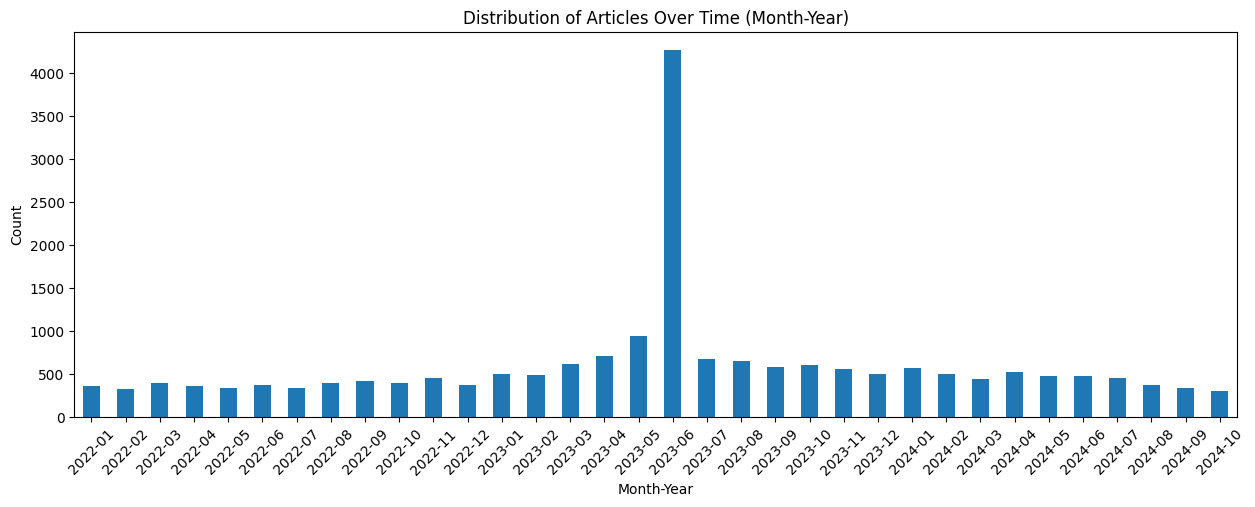

In [ ]:
# Plot distribution by month.year
plt.figure(figsize=(12, 5))
media_df['month_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Distribution of Articles Over Time (Month-Year)")
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The upper bar chart represents the distribution of media articles over time (grouped by Month-Year). A key observation is the extreme spike in June 2023, where the number of articles is significantly higher than any other month. Other months show a more balanced and steady distribution, with a gradual increase in early 2023 and stabilization afterward.

In June 2023, a significant spike in cleantech media coverage was observed, likely due to multiple high-profile industry events. Key events included the Cleantech Forum Asia (Singapore), the ARC Cleantech Innovation Festival (Germany), and the CleanTech Innovation Showcase (Seattle).

The concentration of these global events likely contributed to the increased volume of cleantech-related articles in June 2023.

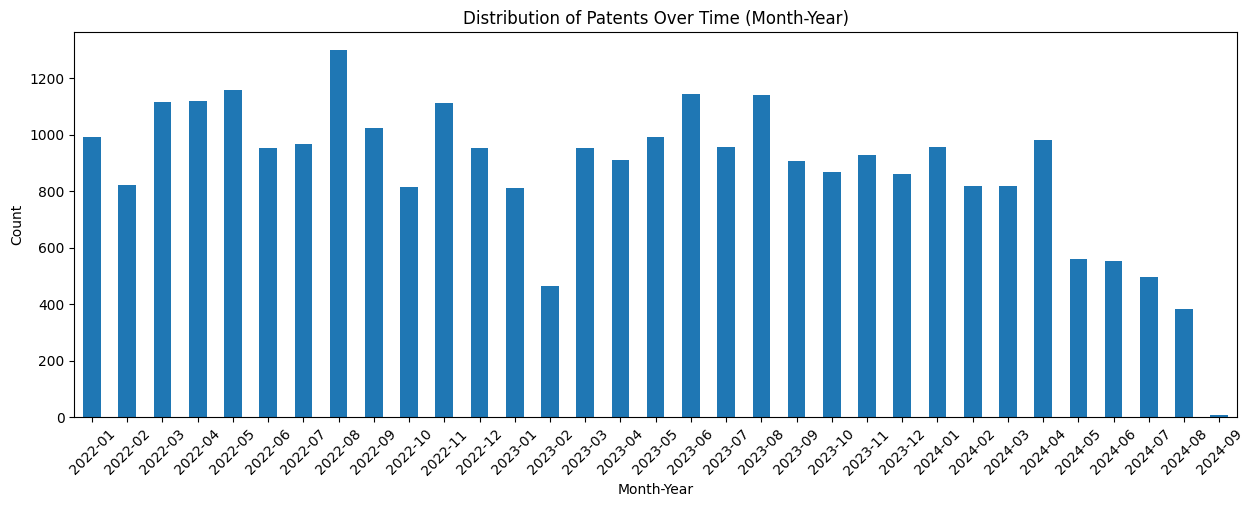

In [ ]:
plt.figure(figsize=(12, 5))
patent_df['month_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Distribution of Patents Over Time (Month-Year)")
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The graph illustrates the monthly distribution of patents from January 2022 to September 2024. Patent activity fluctuates, with a notable peaks in August 2022 and June 2023. A significant drop is observed in February 2023. From early 2024 onward, a gradual decline in patent filings is evident, with a sharp drop after April 2024. This decline may indicate incomplete recent data, decreasing patent activity, or shifts in R&D investment.

In [ ]:
# We will add some basic text features to the data

# Add 'Review lenght'
media_df['title_length'] = media_df['title'].astype(str).apply(len)
# Add simple token count
media_df['number_tokens'] = media_df['title'].apply(lambda x: len(str(x).split()))

# Add 'Review lenght'
patent_df['abrtract_length'] = patent_df['abstract'].astype(str).apply(len)
# Add simple token count
patent_df['abstract_tokens'] = patent_df['abstract'].apply(lambda x: len(str(x).split()))


In [ ]:
media_df.describe()

,id,date,month,title_length,number_tokens
count,20111.000000,20111,20111.000000,20111.000000,20111.000000
mean,75025.468003,2023-06-17 05:38:10.746357504,6.105564,65.705186,9.913629
min,4255.000000,2022-01-02 00:00:00,1.000000,17.000000,4.000000
25%,47462.500000,2023-01-31 00:00:00,4.000000,49.000000,7.000000
50%,90627.000000,2023-06-14 00:00:00,6.000000,62.000000,9.000000
75%,99173.000000,2023-11-28 00:00:00,8.000000,79.000000,12.000000
max,133626.000000,2024-10-24 00:00:00,12.000000,403.000000,58.000000
std,29142.310847,NaN,2.953467,22.566799,3.596029


The distribution suggests that most article titles are relatively short, but some outliers have significantly longer titles.

In [ ]:
patent_df.describe()

,publication_date,month,abrtract_length,abstract_tokens
count,28827,28827.000000,28827.000000,28827.00000
mean,2023-03-24 15:38:25.213862144,6.072051,392.139244,56.86190
min,2022-01-01 00:00:00,1.000000,3.000000,1.00000
25%,2022-08-04 00:00:00,3.000000,313.000000,45.00000
50%,2023-03-24 00:00:00,6.000000,408.000000,59.00000
75%,2023-11-07 00:00:00,9.000000,482.000000,70.00000
max,2024-09-05 00:00:00,12.000000,1645.000000,237.00000
std,NaN,3.318169,133.098926,19.51128


This suggests that while most patents follow a standardized format, there is significant variation in abstract length and detail, possibly reflecting different technical fields or patent submission styles.

In [ ]:
media_df.groupby('domain').size().sort_values(ascending=False)

domain
energy-xprt              4181
pv-magazine              3093
azocleantech             2488
cleantechnica            2089
pv-tech                  1969
thinkgeoenergy           1052
solarpowerportal.co       850
energyvoice               828
solarpowerworldonline     785
solarindustrymag          621
solarquarter              606
rechargenews              573
naturalgasintel           298
iea                       173
energyintel               171
greenprophet              130
greenairnews               59
ecofriend                  55
all-energy                 39
decarbxpo                  20
storagesummit              15
eurosolar                   9
indorenergy                 4
bex-asia                    2
biofuels-news               1
dtype: int64

The table shows the number of articles per media domain. Energy-Xprt (4,181), PV-Magazine (3,093), and Azocleantech (2,488) are the top sources, indicating their strong presence in cleantech reporting. The data follows a long-tail distribution, with a few domains contributing most articles, while niche sources like Biofuels-News (1) and BEX Asia (2) provide minimal coverage. This helps identify key players in the sector.

In [ ]:
patent_df.groupby('country_code').size().sort_values(ascending=False)


country_code
CN    26208
US      881
WO      698
EP      254
KR      234
AU      152
CA      106
TW       42
GB       36
NL       34
JP       28
ES       25
LU       22
MX       21
RU       15
SA       13
SE       10
MD        8
ZA        6
MY        6
RO        4
GR        4
FI        4
DK        3
CZ        3
NZ        2
GE        2
CL        1
EE        1
LV        1
RS        1
TN        1
UA        1
dtype: int64

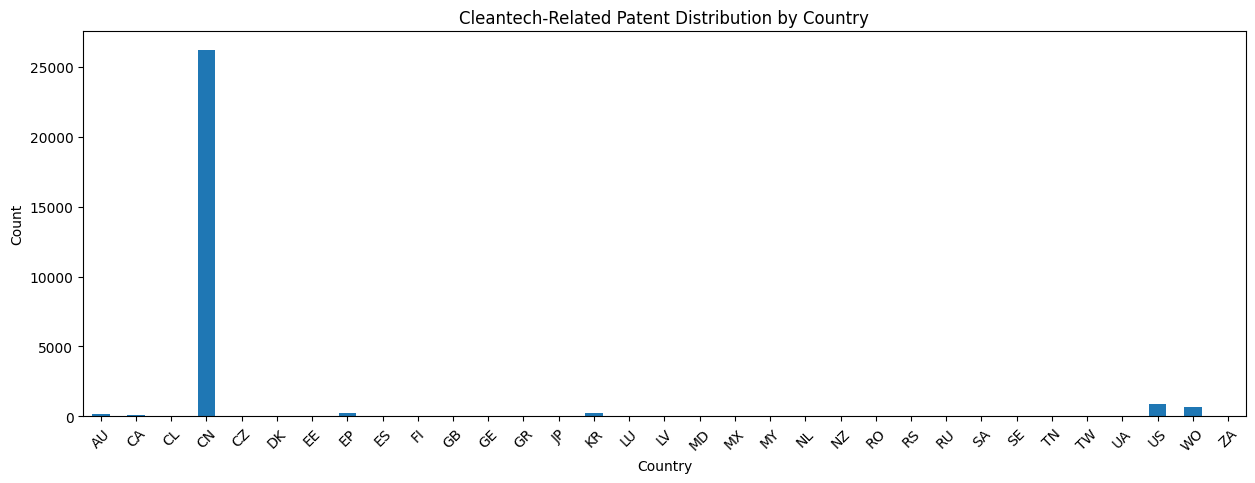

In [ ]:
plt.figure(figsize=(12, 5))
patent_df['country_code'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Cleantech-Related Patent Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The grouped data shows the number of patents filed per country, sorted in descending order. China (CN) dominates with 26,208 patents, significantly higher than the United States (US) with 881 and WO (World Intellectual Property Organization) with 698. Other notable regions include Europe (EP), South Korea (KR), Australia (AU), and Canada (CA). The distribution highlights China's overwhelming lead in patent filings, suggesting a strong focus on cleantech innovation and intellectual property protection.

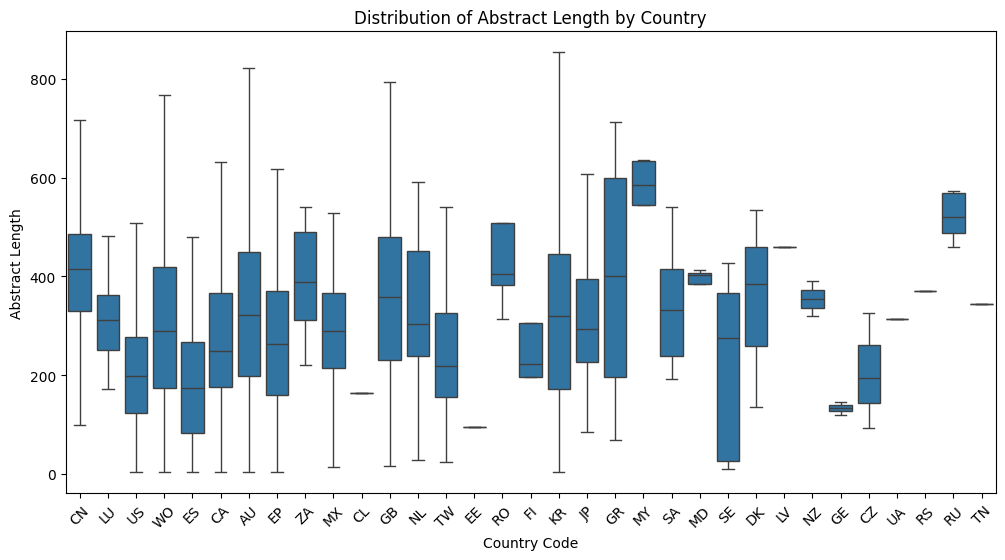

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create boxplot for abstract length by country
sns.boxplot(data=patent_df, x='country_code', y='abrtract_length', showfliers=False)

# Customize plot
plt.xlabel("Country Code")
plt.ylabel("Abstract Length")
plt.title("Distribution of Abstract Length by Country")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

The boxplot highlights variations in patent abstract lengths across countries. While some nations have consistently longer or shorter abstracts, it is important to consider the number of patents per country, as nations with fewer patents may show more variability. High-patent countries like CN, US, and EP provide a broader representation, whereas outliers in smaller datasets may not reflect overall trends.

### Sentiment
The following code performs sentiment analysis on text data from two datasets using the VADER SentimentIntensityAnalyzer from the nltk library. The goal is to assess the sentiment polarity of media content and patent abstracts by computing a compound sentiment score for each entry.

For each text entry, the polarity score is calculated using VADER’s polarity_scores() method, which returns a dictionary of sentiment scores. The compound score, a single value ranging from -1 (strongly negative) to +1 (strongly positive), is extracted and assigned to a new column 'sentiment'. This score helps to quantitatively assess the sentiment of media content and patent abstracts, enabling further analysis on trends, emotional tone, and public perception.

In [ ]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
media_df['sentiment'] = media_df['content'].fillna('').apply(lambda x: sia.polarity_scores(str(x))['compound'])
patent_df['sentiment'] = patent_df['abstract'].fillna('').apply(lambda x: sia.polarity_scores(str(x))['compound'])

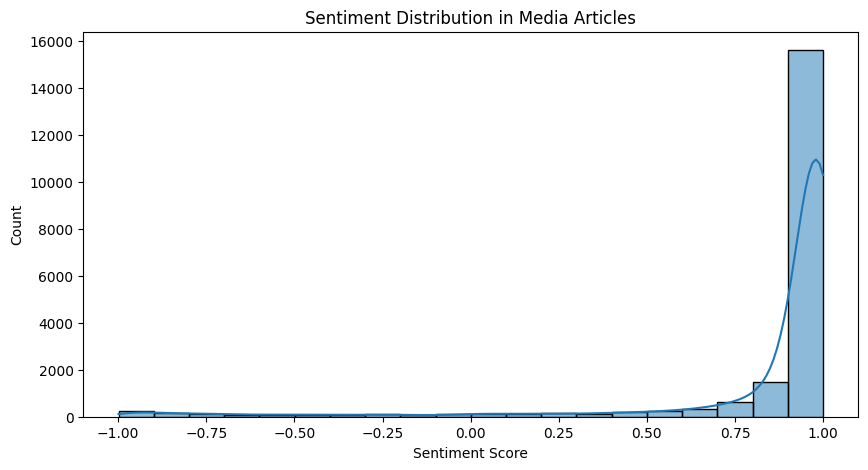

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(media_df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution in Media Articles")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

The sentiment analysis of media articles shows a strong positive bias, with most sentiment scores clustering around +1.0. Negative and neutral sentiments are significantly less frequent. This suggests that the media coverage in the dataset is predominantly positive.

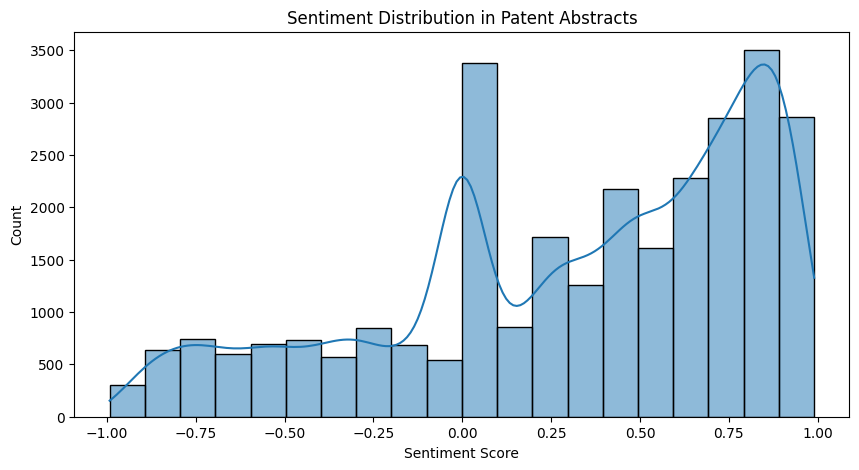

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(patent_df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution in Patent Abstracts")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

The sentiment analysis of patent abstracts shows peaks around neutral (0.0) and positive (0.75-1.0) scores. Negative sentiments are less frequent but still present, indicating that patent abstracts tend to be either neutral or slightly optimistic in tone.

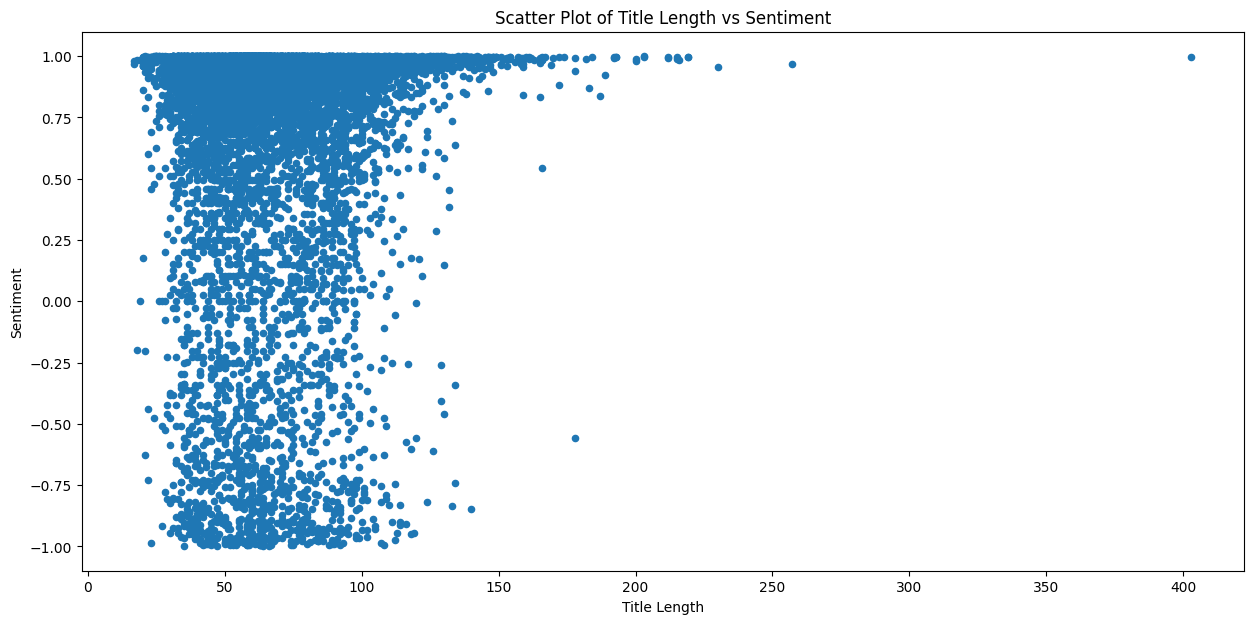

In [ ]:
media_df.plot(kind='scatter', x='title_length', y='sentiment', figsize=(15,7))
plt.xlabel('Title Length')
plt.ylabel('Sentiment')
plt.title('Scatter Plot of Title Length vs Sentiment')
plt.show()

Most titles are short (<100 characters) and strongly positive (1.0 sentiment). Longer titles are rare and show mixed sentiment. No clear correlation between title length and sentiment.

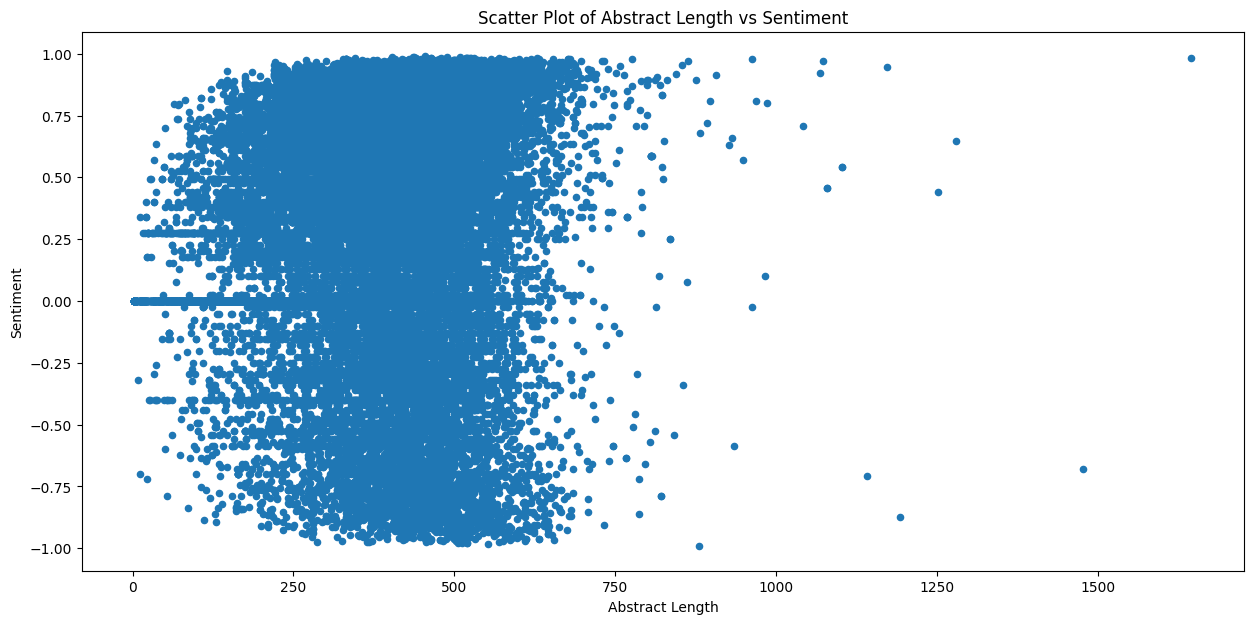

In [ ]:
patent_df.plot(kind='scatter', x='abrtract_length', y='sentiment', figsize=(15,7))
plt.xlabel('Abstract Length')
plt.ylabel('Sentiment')
plt.title('Scatter Plot of Abstract Length vs Sentiment')
plt.show()

Most abstracts are under 500 characters and show a wide range of sentiment values. Sentiment distribution appears balanced, with both positive and negative scores. Longer abstracts are rare and also as before do not show a clear sentiment trend.

Text(0.5, 1.0, 'Media Bigrams w/o stopwords')

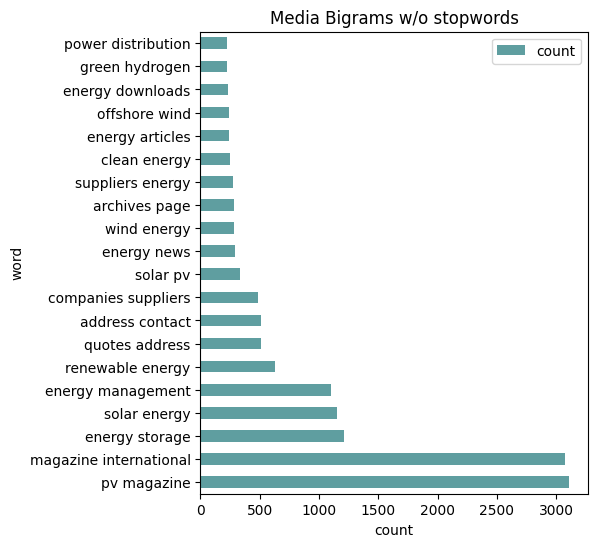

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(media_df['title'], 20)
bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Media Bigrams w/o stopwords')

The most common bigrams highlight key topics like solar energy, energy storage, and renewable energy. "PV magazine" appears most frequently, suggesting a major industry source. These terms indicate the primary focus areas in cleantech media.

Text(0.5, 1.0, 'Media Trigrams w/o stopwords')

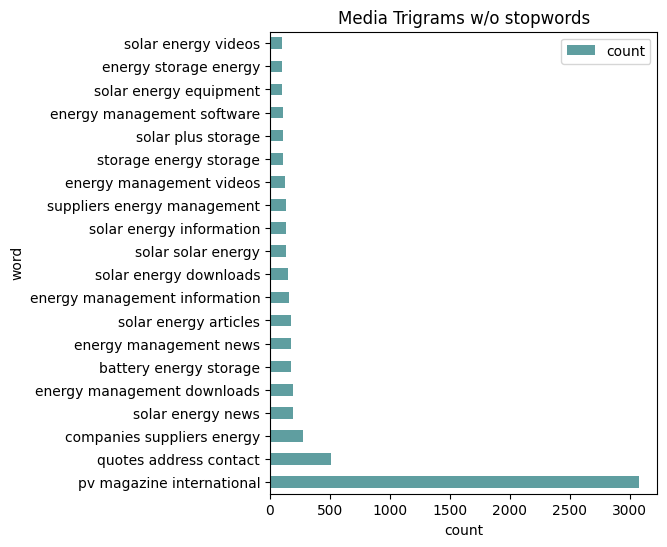

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(media_df['title'], 20)
trigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Media Trigrams w/o stopwords')

"PV magazine international" appears most frequently, reinforcing its role as a dominant industry source. The most frequent trigrams emphasize solar energy, energy storage, and energy management.

Text(0.5, 1.0, 'Patent Bigrams w/o stopwords')

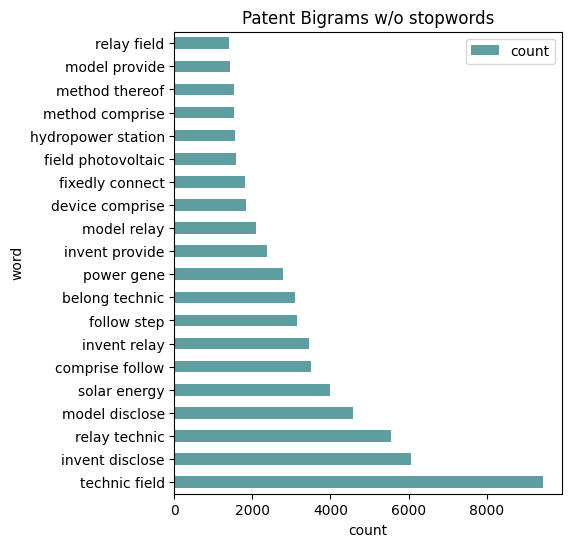

In [ ]:
common_words = get_top_n_bigram(patent_df['abstract'].dropna(), 20)
bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Patent Bigrams w/o stopwords')

The most frequent bigrams highlight technical terminology such as "technic field," "invent disclose," and "solar energy." The frequent use of "model" and "relay" suggests a strong focus on engineering and innovation in patent documentation.

Text(0.5, 1.0, 'Patent Trigrams w/o stopwords')

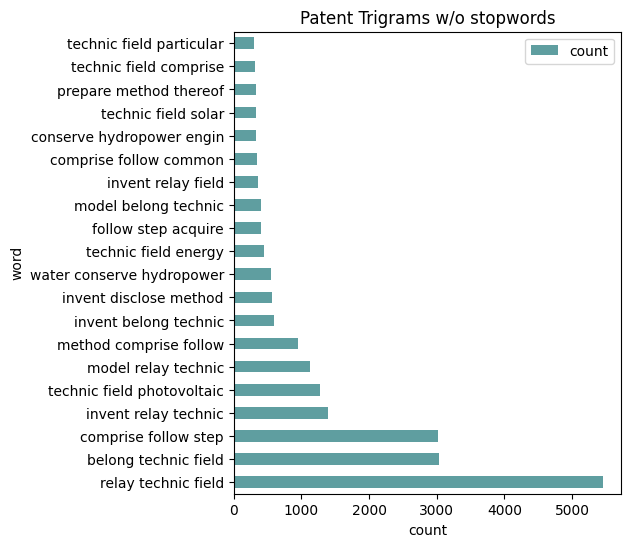

In [ ]:
common_words = get_top_n_trigram(patent_df['abstract'].dropna(), 20)
trigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Patent Trigrams w/o stopwords')

The trigrams further refine key concepts, with phrases like "relay technic field," "belong technic field," and "comprise follow step." These terms indicate a focus on technical processes, energy management, and patent disclosures.

### Named Entity Recognition (NER) using spaCy

In [ ]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Named Entity Recognition (NER) using spaCy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]


media_df['entities'] = media_df['content'].fillna('').apply(lambda x: extract_entities(str(x)))

In [ ]:
save_path = "../cleaned_data/media_dataset_cleaned_entity.csv"
media_df.to_csv(save_path, index=False)

In [ ]:
patent_df['entities'] = patent_df['abstract'].fillna('').apply(lambda x: extract_entities(str(x)))

In [ ]:
save_path = "../cleaned_data/google_patent_cleaned_entity.csv"
patent_df.to_csv(save_path, index=False)

In [ ]:
# Co-occurrence Matrix
entity_pairs = []
for entities in media_df['entities'].dropna():
    entity_pairs.extend([(e1, e2) for i, e1 in enumerate(entities) for e2 in entities[i+1:]])
for entities in patent_df['entities'].dropna():
    entity_pairs.extend([(e1, e2) for i, e1 in enumerate(entities) for e2 in entities[i+1:]])

co_occurrence = Counter(entity_pairs)
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)

# Visualizing Co-occurrence Matrix
plt.figure(figsize=(12, 6))
sns.barplot(y=co_occurrence_df['Pair'].astype(str)[:20], x=co_occurrence_df['Count'][:20], palette="viridis")
plt.xlabel("Count")
plt.ylabel("Entity Pair")
plt.title("Top 20 Entity Co-occurrences")
plt.show()

In [ ]:
# Graph Visualization
G = nx.Graph()
for (e1, e2), count in co_occurrence.items():
    G.add_edge(e1, e2, weight=count)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(e1, e2): count for (e1, e2), count in co_occurrence.items() if count > 5}, font_size=8)
plt.title("Entity Co-occurrence Graph")
plt.show()

In [ ]:
# K-Means Clustering on Entity Co-occurrences
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
entity_texts = [' '.join(pair) for pair in co_occurrence_df['Pair']]
X = vectorizer.fit_transform(entity_texts)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, max_iter=50, tol=0.01, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_.tolist()

# Display Clustered Entities
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = np.array(vectorizer.get_feature_names_out())
for i, cluster_terms in enumerate(centroids):
    print("Cluster #{}: {}".format(i, ", ".join(terms[cluster_terms[:8]])))

 ### Word Clouds
 Word Cloud Analysis
To visualize the most frequently used words in media articles and patent abstracts, we generate word clouds. This technique helps identify dominant themes and key terms by displaying words in varying sizes based on their frequency.

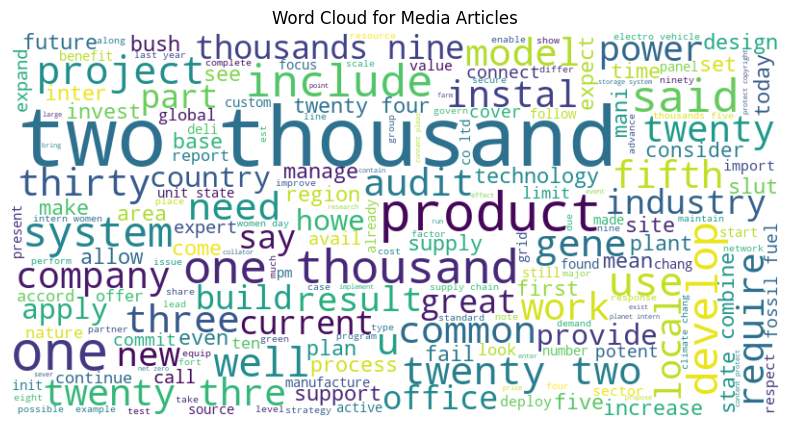

In [ ]:
# Word Clouds
media_text = ' '.join(media_df['content'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(media_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Media Articles")
plt.show()

The dominant terms include "two thousand," "projects,", "product," "industry" and "power". This suggests that the media coverage focuses heavily on industrial developments and energy projects related to cleantech.

The presence of numerical values like "one thousand," "twenty," and "thirty" indicates frequent mentions of years, financial figures, or project scales. Words such as "develop," "supply," "generate," and "design" emphasize a strong focus on innovation, infrastructure, and renewable energy initiatives.

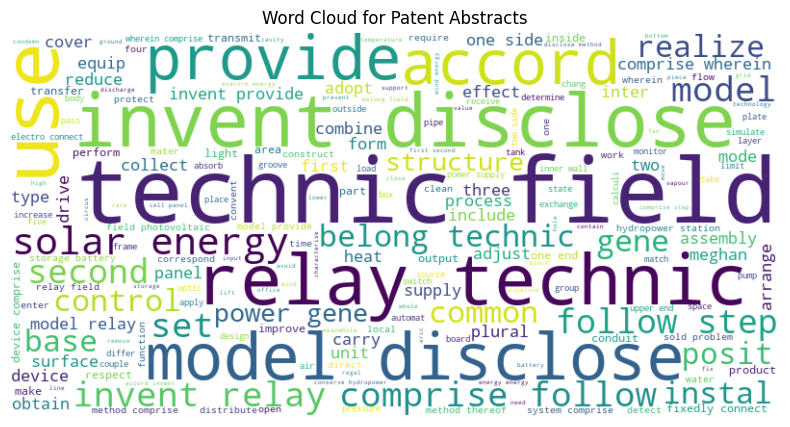

In [ ]:
patent_text = ' '.join(patent_df['abstract'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(patent_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Patent Abstracts")
plt.show()

The word cloud for patent abstracts highlights key terms frequently appearing in the dataset. Dominant words such as "technic," "field," "disclose," "invent," and "provide" suggest a strong focus on technical innovation, disclosures, and inventions.

Terms like "solar," "energy," "relay," and "gene" indicate that many patents relate to renewable energy, electrical systems, and biotechnology. Additionally, words such as "structure," "process," and "assembly" emphasize the technical and engineering aspects of patent filings.

Check file

2.2_exploratory_data_and_text_analysis for this part

2.2.1_exploratory_text_analysis_I

## Topic Modeling
To **identify hidden themes and emerging trends**, we apply topic modeling techniques on both datasets:  

- **Latent Dirichlet Allocation (LDA)** and **Non-Negative Matrix Factorization (NMF)** to uncover broad thematic structures.  
- **Top2Vec** and **BERTopic** for **more dynamic and context-aware topic modeling**.  
- **Comparing Media vs. Patents**:  
  - Which Cleantech topics are **gaining media attention** but **not patented** yet?  
  - Are **patents aligned with market trends**, or do they focus on different areas?  
  - **What are the innovation gaps** between research and real-world applications?  

By the end of this step, we will have a **structured view of the Cleantech landscape**, highlighting **key trends, players, and technological opportunities**.


Check file

2.2_exploratory_data_and_text_analysis for this part

2.2.2_exploratory_text_analysis_II
